<a href="https://colab.research.google.com/github/Userfound404/QML-HEP-GSOC-2023/blob/main/GsoC_task_8_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 8
Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

### History

**Vision Transformers (ViT)** is a computer vision architecture that uses a transformer-based model for image classification tasks. This model was introduced in 2020 by Google researchers, and it has achieved state-of-the-art performance on several benchmark datasets.




### Architecture

There are two main components involved, one is the transformer encoder and classification head 

#### Transformer Encoder

The input sequence is divided into tokens and processed by numerous transformer layers in the transformer encoder, which is similar to the one used in tasks involving natural language processing. The input image is split into a predetermined number of non-overlapping patches in ViT, and these patches are then flattened into 1D token sequences.

The output of the final transformer layer is used as a feature representation of the image after these patches have been processed by several additional transformer layers.


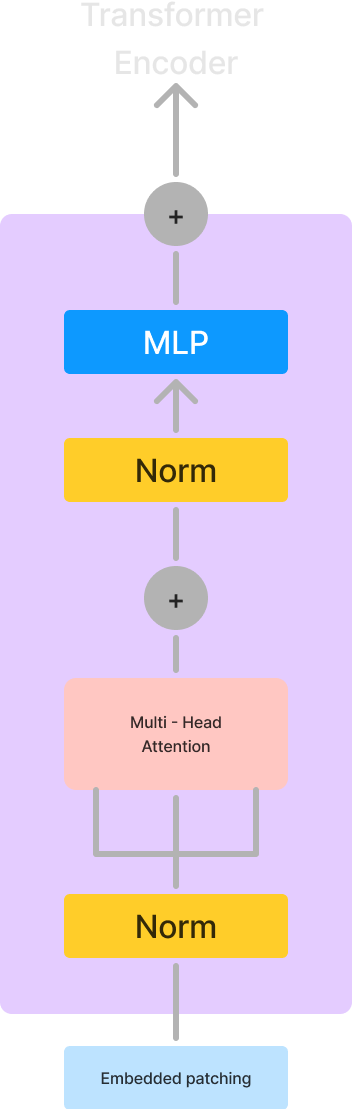

### Patch Embedding

In patch embedding, an image is divided into a set of non-overlapping patches, each of which is represented by a learnable embedding. The patches are typically rectangular in shape and have a fixed size. The size of the patches depends on the specific application where in our MNIST images are of size `28 x 28` and we make them into `7 x 7` patches

To convert an image into a sequence of embeddings, each patch is flattened into a one-dimensional vector, and then a linear projection is applied to map the vector to a higher-dimensional space.

the following is a detailed description with reference to paper[1].

In the first step, an input image of shape $(height, width, channels)$ is embedded into a feature vector of shape $(n+1, d)$, following a sequence of transformations.

$$
Z_o = [ x_{class} ; x_p^1E ; x_p^2E; ... ; x_p^NE] + E_{pos},
\\
E ∈ ℝ^{(P^2 . C) 𝖷 D} , E_{pos} ∈ ℝ^{(N+1) 𝖷 D}
$$

1. The image is divided into n square patches of shape $(p, p, c)$ in raster order, where $p$ is a predefined parameter (left to right, up to down).

2. The patches are flattened, resulting in n line vectors of shape $(1, p²*c)$.

3. The flattened patches are multiplied with a trainable embedding tensor of shape $(p²*c, d)$, which learns to linearly project each flat patch to dimension d. The majority of the components use this dimension d, which is constant throughout the architecture. The result is n embedded patches of shape $(1, d)$.

4. The list of patch embeddings has a learnable $[cls]$ token appended at the end with the shape $(1, d)$. The concept behind this token comes from the BERT paper, which only feeds the final representation (the output of transformer L) through the classification layers.

5. A trainable positional embedding tensor, $E_{pos}$, with the same shape, $(n+1, d)$, is added to the concatenated sequence of projections. This tensor learns 1D positional information for each of the patches, in order to add a spatial representation of each patch within the sequence.

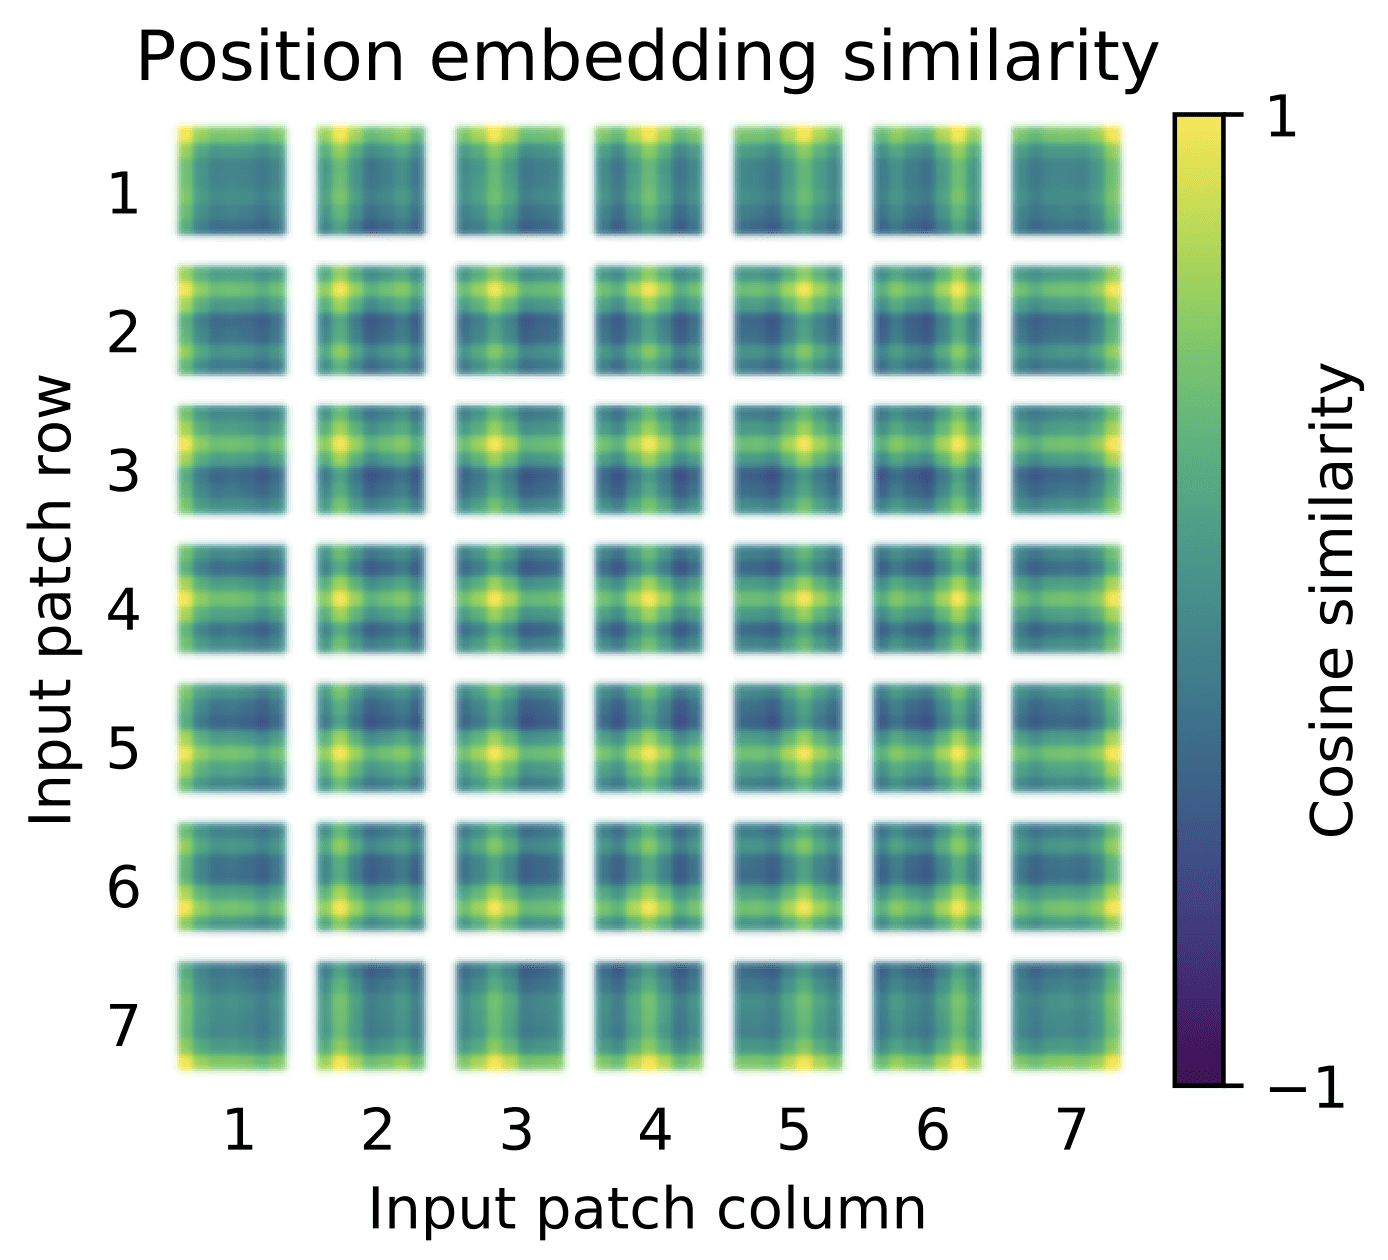

### Transformer Encoder

The network learns more abstract features from the embedded patches. It uses a stack of L transformer encoders

The neural netword learns about more abstract features from the output of embedded patches.
We use a stack of L transformer encoders. This corresponds to equations (2) and (3) from the paper.

$$
z_l^ʼ = MSA(LN(z_{l-1})) + z_{l-1},  l = 1 ... L
\\
z_l = MLP(LN(z_l^ʼ)) + z^ʼ_l, l = 1 ... L
$$

The encoder component contains a multi-headed attention (MHA) mechanism and a 2-layer MLP, with layer normalization and residual connections in between.

Layer normalization is used to stabilize hidden state dynamics and to reduce the training time.

The trainable weights lie inside the MHA mechanism and the MLP weights. There are two MLP weights, hidden and output and their weight matrices are:
- $W_h$ of shape $(d, d_{mlp})$
- $W_o$ of shape $(d_{mlp}, d)$

#### Multi-Head Attention

The multi-head attention (MHA) step, included in each of the L stacked transformers, corresponds to equations (5), (6), (7), and (8) from the paper’s appendix.

$$
 [ q, k ,v ] = z U_{qkv}, U_{qkv} ∈ ℝ^{D × 3 D_h}, (5)
 \\
 A = softmax(qk^t / \sqrt{D_h}), A ∈ ℝ^{N × N},(6)
 \\
 SA(z) = Av(7)
 \\
 MSA(z) = [SA_1(z); SA_2(z); ... ; SA_k(z)]U_msa, U_msa ∈ ℝ^{k. D_h × D} (8)
$$

The multi-head attention mechanism in an encoder splits the previous hidden state into K heads, each of which learns from different aspects of the representation. Each head is projected into 3 sub-spaces using trainable matrices, representing query, key, and value. 

Scaled dot-product attention is applied to each head to compute a probability distribution of attention weights, which is then used to compute a weighted average of the values. The self-attention matrices from each head are concatenated and multiplied by a trainable linear layer to produce a final representation that aggregates features from all heads.

### Classification head

In the classification head, the $[cls]$ token is only used in its final representation. A 2-layer MLP is used for pre-training, so there are two weight matrices: Wh of shape $(d, d_{mlp})$ and Wo of shape $(d_{mlp}, d)$.

 A single linear layer is used for fine-tuning, so there is only one tensor, having the shape $(d, n_cls)$. In each scenario, the network's final output is a vector with the shape $(1, n_cls)$, which contains the probabilities related to each of the $n_cls$ classes.

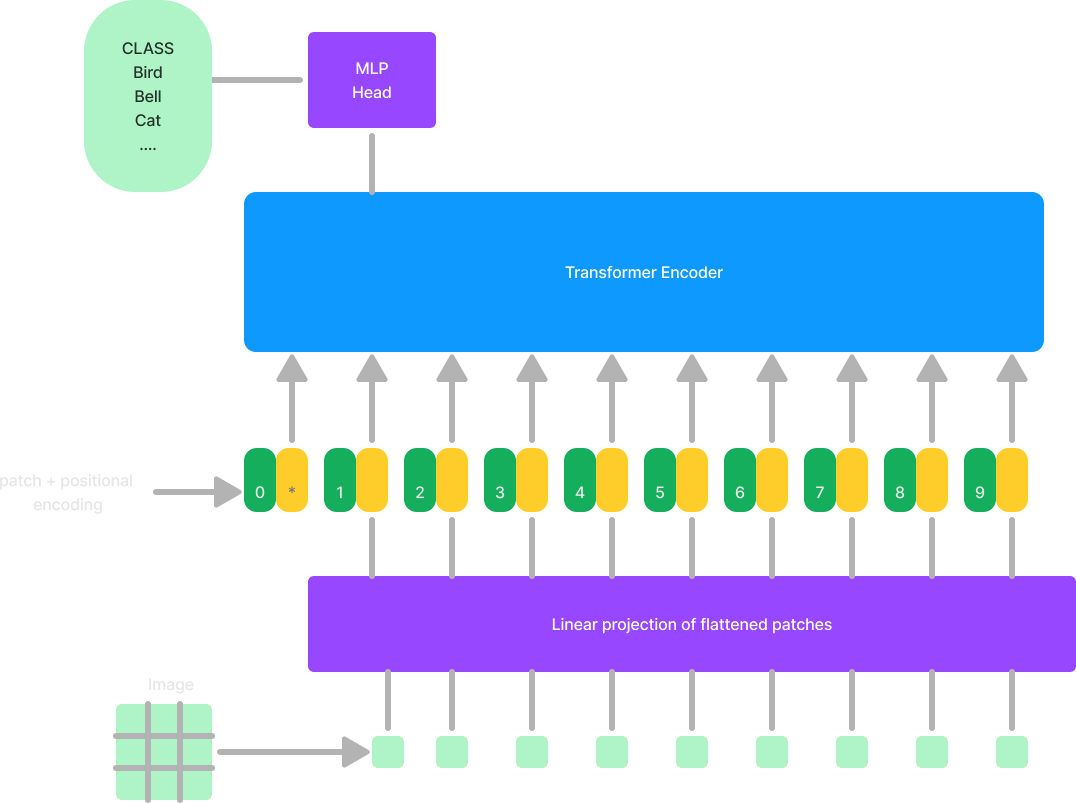

fig - Vision Transformers (ViT)

Let's implement the code for the above architecture:

In [ ]:
# Defining Gelu
def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))


def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.
      Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.
      Returns:
        output, attention_weights
      """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


In [ ]:
class VisionTransformer(tf.keras.Model):
    def __init__(
            self,
            image_size,
            patch_size,
            num_layers,
            num_classes,
            d_model,
            num_heads,
            mlp_dim,
            channels=3,
            dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model)
        )
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))
        self.patch_proj = Dense(d_model)
        self.enc_layers = [
            EncoderLayer(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential(
            [
                LayerNormalization(epsilon=1e-6),
                Dense(mlp_dim, activation=gelu),
                Dropout(dropout),
                Dense(num_classes),
            ]
        )

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        patches = self.extract_patches(x)
        x = self.patch_proj(patches)

        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        for layer in self.enc_layers:
            x = layer(x, training, None)

        # First (class token) is used for classification
        x = self.mlp_head(x[:, 0])
        return x


if __name__ == '__main__':
    image = np.ones((1, 32, 32, 1))
    model = VisionTransformer(32, 4, 4, 10, 64, 4, 128, 1)
    labels = model(image, False)
    print(labels.shape)



(1, 10)


In [ ]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

model = VisionTransformer(28, 4, 4, 10, 64, 4, 128, 1)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

11490434/11490434 [==============================] - 0s 0us/step


Epoch 1, Loss: 0.22384393215179443, Accuracy: 93.19000244140625, Test Loss: 0.15649637579917908, Test Accuracy: 95.31000518798828
Epoch 2, Loss: 0.17344433069229126, Accuracy: 94.73833465576172, Test Loss: 0.11326929181814194, Test Accuracy: 96.87999725341797
Epoch 3, Loss: 0.14600765705108643, Accuracy: 95.62332916259766, Test Loss: 0.09155455976724625, Test Accuracy: 97.20999908447266
Epoch 4, Loss: 0.12982359528541565, Accuracy: 96.01499938964844, Test Loss: 0.09296884387731552, Test Accuracy: 97.0999984741211
Epoch 5, Loss: 0.11407871544361115, Accuracy: 96.5250015258789, Test Loss: 0.11663912236690521, Test Accuracy: 96.58000183105469
Epoch 6, Loss: 0.10641952604055405, Accuracy: 96.77666473388672, Test Loss: 0.08282618969678879, Test Accuracy: 97.33999633789062
Epoch 7, Loss: 0.09900472313165665, Accuracy: 96.96166229248047, Test Loss: 0.09801144152879715, Test Accuracy: 97.20999908447266
Epoch 8, Loss: 0.09391090273857117, Accuracy: 97.1500015258789, Test Loss: 0.085708186030387

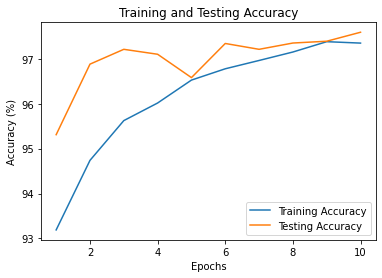

In [ ]:

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


EPOCHS = 10
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    train_acc = train_accuracy.result() * 100
    test_acc = test_accuracy.result() * 100

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    
plt.plot(range(1, EPOCHS + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accs, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

**we could get a test accuracy of 97.58**

### To Quantum

I Have two ideas on how we can implement

1.**Quantum Embedding**-

  source - [Quantum embeddings for machine learning](https://arxiv.org/pdf/2001.03622.pdf)

  The idea is to embed classical data points as quantum states and then compare them using optimal quantum measurements. The embedding is adjusted adaptively to train the quantum classifiers.

  The authors propose training the first part of the circuit, the embedding, with the objective of maximally separating data classes in Hilbert space. They're calling this **"quantum metric learning."** By doing so, the measurement minimizing a linear classification loss is already known and depends on the metric used: for embeddings separating data using the `1` or trace distance, this is the Helstrøm measurement, while for the `2` or Hilbert-Schmidt distance, it is a simple overlap measurement.

  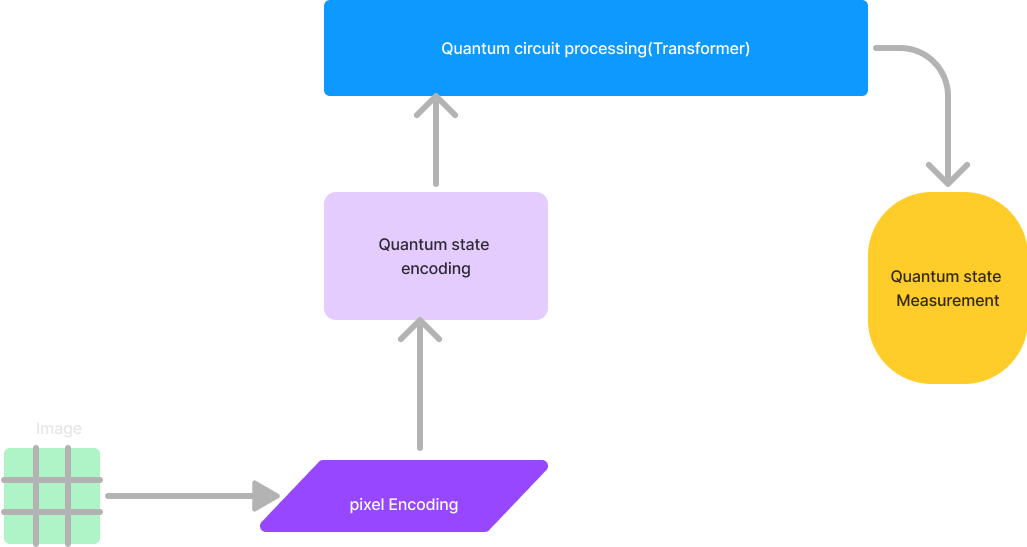

  **Pixel Encoding**: The first step is to encode the image pixels into quantum states. One way to do this is to use the quantum amplitude encoding method. According to this method, the value of a pixel in the image is determined by the amplitude of each quantum state. A pixel with a value of 0.2,this might be represented by a quantum state with an amplitude of 0.2 if the pixel values are normalised between 0 and 1.

  **Quantum State Encoding**: The quantum state must now be prepared. In order to do this, a quantum circuit that can prepare the state based on the encoded pixels must be created. The circuit can consist of operations that manipulate the amplitudes of the quantum state, such as rotations and phase shifts.

  The size of the image and the desired resolution would determine the ideal number of qubits for the circuit. For a 256x256 pixel image, for instance, a 16 qubit circuit could be used.

  **Quantum circuit Processing**: Once the quantum state is ready, it can be processed by a quantum circuit that executes the operations completed by the conventional transformer layers. This circuit might include operations for layer normalisation, feedforward layers, and multi-head attention. The number of layers in the transformer and the complexity of the operations carried out in each layer would determine the number of qubits necessary for the circuit.

  **Quantum state measurement**: Finally, the output of the quantum circuit can be measured to obtain the result of the transformer operation. The measurement result would be a conventional output that could be applied to later tasks like object or image detection.  


2. **Hybrid Approach**

  source - [A Hybrid Quantum-Classical Neural Network Architecture for Binary Classification](https://arxiv.org/pdf/2201.01820.pdf)

  The hybrid approach for quantum vision transformers combines classical and quantum processing to leverage the strengths of both. Here's how it can be used:
  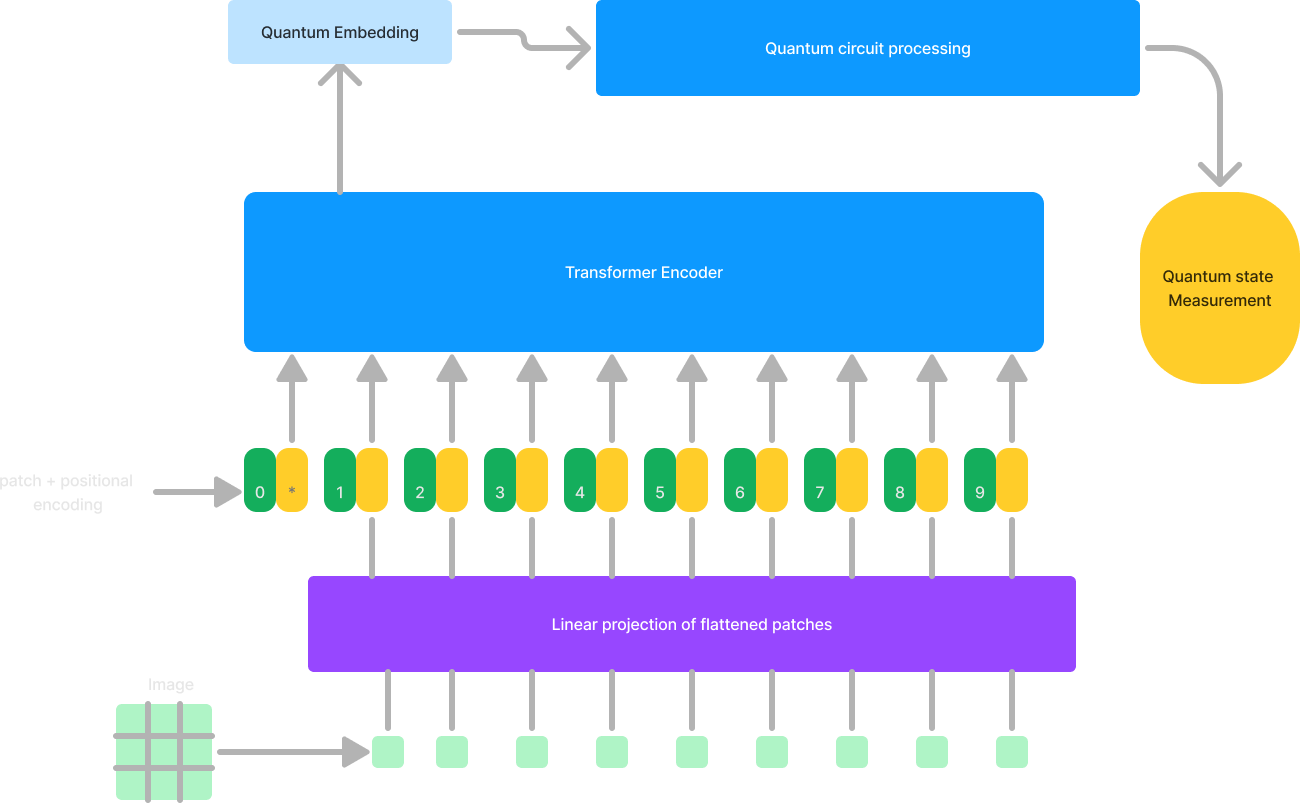

  **Classical processing**: To extract local features, classical transformer layers are applied to the input image first. These layers could consist of multi-head attention and feedforward layers, similar to those used in classical transformers. A series of feature vectors is what the traditional transformer layers produce as their output.

  **Quantum embedding**: Quantum embedding techniques are then used to map the feature vectors into a quantum state. This involves encoding the feature vectors into the amplitudes of a quantum state using a quantum circuit.

  **Quantum processing**: The quantum state is then processed by quantum transformer layers to capture global relationships between the features. These layers could consist of quantum circuits that perform multi-head attention and feedforward operations, similar to those used in classical transformers

  **Quantum state measurement**: Finally, the output of the quantum circuit can be measured to obtain the result of the transformer operation. The measurement result would be a conventional output that could be applied to later tasks like object or image detection. 




source : [AN IMAGE IS WORTH $16X16$ WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf)